In [5]:
# Standard Data Science Utility Belt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# User defined methods
from acquire import acquire
from prepare import prepare

# Modeling Stuff

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize
import sklearn.preprocessing
import re
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from model import  vectorizer_split, tfidf_split, test_a_model, make_models_and_print_metrics_test_data, print_metrics
# Viewing Options
pd.set_option("display.max_rows", None, "display.max_columns", None) 
pd.reset_option("display.max_rows", "display.max_columns")

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Project Planning

### Project and Goals

    To construct a classification model that would accurately predict the programming language that was used in a GitHub repository by scraping their respective readme.md files.

### Original Hypothesis

    The best predictor for language would be the frequency of referencing that language in the README.md

### Domain Knowledge Quick Tip
    You can add a README file to a repository to communicate important information about your project. A README, along with a repository license, citation file, contribution guidelines, and a code of conduct, communicates expectations for your project and helps you manage contributions
    
    A README is often the first item a visitor will see when visiting your repository. README files typically include information on: What the project does, why the project is useful, how users can get started with the project, where users can get help with your project, and who maintains and contributes to the project

### The Plan
    
    Create a github community for our team.
    
    Setup a Repository for our project
    
    Split up responsibilities among Josh C., Brooke, Curtis, and Brandon
    
    Acquire a list of repositories names by web scrapping github
    
    Use the github API to pull the data using the prebuilt acquire.py script
    
    Clean the data
    
        - Lowercase
        - Character encoding
        - Drop anything that isn't an ASCII
        - Remove anything that is not a through z, a number, a single quote, or whitespace
        - Tokenize
        - Document
    
    Explore the data
    
        - Find trends
        - Make graphs
        - Ask questions
        - Answer those questions
        - Document findings
        
    Model the data
    
        - Using aclassification methodologies
        - Create at least three models
        - Document findings
        
    Evaluate the data
    
        - Analize the results of our model. Look for drop offs in train/validate
        
    Run the best model
    
        - Run our best validate model on data our model has not seen
        - Document results
        
    Work Deliverables
    
        - Final Notebook
        - Slide Deck
        - Video
    

# Executive Summary - Conclusions & Next Steps

### Conclusion
    Our model could accuratley predict the language of the repos by 62% which had beat double the baseline model of 31%. Further cleaning of common words or stop words may improve the accuracy of the model. C# gave our models the hardest time with misclassifications of every other langauge falling under the C# moniker. 

### Recommendation

    We Recommend adding more GitHub repositories README.md files to the dataset to help prevent overfitting and to possibly increase the model accuracy

### Key Takeaways

    123 entries in total

    List of repos we gathered were mostly coded HTML, C#, Python, and JavaScript

    C# gave or models the biggest problem causing the most misclassifications because was shared common words, could try filtering those common words to improve accuracy

# Data Acquisition

In [3]:
df = acquire()

### .info(), .head(), .describe()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             121 non-null    object
 1   language         119 non-null    object
 2   readme_contents  121 non-null    object
dtypes: object(3)
memory usage: 3.0+ KB


In [5]:
df.head()

,repo,language,readme_contents
0,iterativv/NostalgiaForInfinity,Python,# NostalgiaForInfinity\nTrading strategy for t...
1,cl2333/Grokking-the-Coding-Interview-Patterns-...,Python,# [Grokking-the-Coding-Interview-Patterns-for-...
2,edeng23/binance-trade-bot,Python,# binance-trade-bot\n\n![github](https://img.s...
3,donnemartin/system-design-primer,Python,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...
4,dortania/OpenCore-Legacy-Patcher,Python,"<div align=""center"">\n <img src=""i..."


In [6]:
df.describe().T

,count,unique,top,freq
repo,121,121,w3c/html,1
language,119,5,HTML,29
readme_contents,121,119,,3


### Distribution - "language"

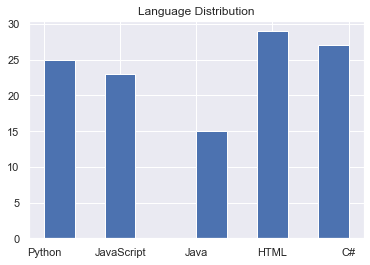

In [7]:
sns.set(font_scale = 1)
df['language'].hist()
plt.title('Language Distribution')
plt.show()

### Data Dictionary

In [8]:
#print(get_data_dictionary(df).to_markdown())

## Target Feature - 'language'

In [9]:
df.language.value_counts(dropna = False)

HTML          29
C#            27
Python        25
JavaScript    23
Java          15
NaN            2
Name: language, dtype: int64

### Acquire takeaway
    - 123 entries in total
    - mostly HTML, C#, Python and JavaScript
    - only three columns

# Prepare

#### Dropped Columns

    No Columns were dropped.

#### Handle Nulls

    There were only two null observations for our target feature.  They got dropped. 

#### Convert Data Types

    No features needed converting of data type. 

#### Rename

    No columns were renamed.

#### Engineered Features

    Three features were engineered: clean, stemmed, and lemmatized. 
    
    'clean'
        - All text was converted to lowercase letters from readme_contents
        - Removed any inconsistencies in unicode character encoding from readme_contents
        - Dropped anything that isn't an ASCII character from readme_contents
        - Removed anything that is not a through z, a number, a single quote, or whitespace from readme_contents
        - Tokenized the readme_contents.  This means, breaking text down into discrete words, punctuation, etc.
        - Removed stop words from readme_contents.  These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. 
    
    'stemmed'
        - We create new words by attaching affixes in a process known as inflection. For example, "calls", "called", and "calling" all share the base stem "call". Stemmed from clean.
        
    'lemmatized'
        - Lemmatization is very similar to stemming, however, the base form in this case is known as the root word, but not the root stem. The difference is that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Lemmatized from clean.

#### Removed Outliers

    - Java only had 15 observations so any repo project written in java got dropped.
    - Ruby only had 1 observation so any repo project written in ruby got dropped.
    - Shell only had 1 observation so any repo with project written in shell got dropped.
        
#### Scaling

    No scaling was preformed.
        
#### Split

    Split data into three data frames:
    
        - train
        - validate
        - test
        
    Used a random_state of 123
    Stratified on our target feature, language

### Prepare Takeaway

    - All features and observations have no null or empty values.
    - test_train_split were stratified on my target feature language

# Exploration

In [6]:
train, validate, test = prepare(acquire())

### First, let's explore the initial hypothesis that ReadME's refer to their own language frequently.

### Additional hypotheses to explore:

    Does the average length of ReadME's differ significantly per language?
    
    Are there any top bigrams or trigrams per language in train that stand out as meaningful?

****
Exploring inital hypothesis of is the language of the ReadME referenced with high frequency?

In [7]:
ADDITIONAL_STOPWORDS = ['9']

def clean_up(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [8]:
html_words = clean_up(' '.join(train[train.language == 'HTML'].clean))
python_words = clean_up(' '.join(train[train.language == 'Python'].clean))
C_sharp_words = clean_up(' '.join(train[train.language == 'C#'].clean))
JavaScript_words = clean_up(' '.join(train[train.language == 'JavaScript'].clean))

In [9]:
all_words = clean_up(' '.join(train.clean))

In [10]:
html_freq = pd.Series(html_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
C_sharp_freq = pd.Series(C_sharp_words).value_counts()
JavaScript_freq = pd.Series(JavaScript_words).value_counts()

In [13]:
all_freq = pd.Series(all_words).value_counts()

In [14]:
print('Top Ten Words for HMTL ReadMEs')
print(html_freq.head(10))
print ("--------------")
print('Top Ten Words for Python ReadMEs')
print(python_freq.head(10))
print ("--------------")
print('Top Ten Words for C# ReadMEs')
print(C_sharp_freq.head(10))
print ("--------------")
print('Top Ten Words for JavaScript ReadMEs')
print(JavaScript_freq.head(10))
print ("--------------")
print('Top Ten Words for ALL ReadMEs')
print(all_freq.head(10))

Top Ten Words for HMTL ReadMEs
file              64
15001700          62
use               58
html              58
dom               50
targetblankimg    40
20002200          38
html5             36
php               30
option            29
dtype: int64
--------------
Top Ten Words for Python ReadMEs
yes        1615
unknown     906
apikey      560
video       487
python      399
data        387
api         333
file        304
format      290
library     218
dtype: int64
--------------
Top Ten Words for C# ReadMEs
string         143
var            141
use            139
csharp         133
c              130
redis          129
new            122
public         115
type           106
messagepack    103
dtype: int64
--------------
Top Ten Words for JavaScript ReadMEs
const         263
javascript    246
function      223
bad           201
good          184
1             178
return        126
foo           116
use           104
eslint         93
dtype: int64
--------------
Top Ten Words for 

## Takeaway from top ten words:

    Top ten words seems to confirm the hypothesis that each ReadME does indeed refer to its own language with high frequency.
    
    Additionally, domain specific words for thier own language do tend to show up more frequently for each ReadME.

### Now exploring the average character length by language:

In [15]:
train['length'] = [len(i) for i in train.clean]

In [16]:
print('The mean character length for HTML ReadME')
print(train[train.language == 'HTML'].mean())
print('----------------------------')
print('The mean character length for Python ReadME')
print(train[train.language == 'Python'].mean())
print('----------------------------')
print('The mean character length for C# ReadME')
print(train[train.language == 'C#'].mean())
print('----------------------------')
print('The mean character length for JavaScript ReadME')
print(train[train.language == 'JavaScript'].mean())
print('----------------------------')

The mean character length for HTML ReadME
length    3247.071429
dtype: float64
----------------------------
The mean character length for Python ReadME
length    27273.4
dtype: float64
----------------------------
The mean character length for C# ReadME
length    9206.0
dtype: float64
----------------------------
The mean character length for JavaScript ReadME
length    11612.9
dtype: float64
----------------------------


In [17]:
train.groupby(by = 'language').mean()

,length
language,
C#,9206.000000
HTML,3247.071429
JavaScript,11612.900000
Python,27273.400000
Ruby,3209.000000
Shell,1111.000000


### Takeaway looking at character length of ReadMEs:

    JavaScript ReadMEs appear to be the longest
    
    Python and C# are fairly similar in length
    
    HTML ReadMEs appear to be the shortest

### Moving forward in Explore, let's see if there are bigrams or trigrams that stand out as meaningful:

In [18]:
html_top_words = ' '.join(train[train['language'] == 'HTML'].clean)
python_top_words = ' '.join(train[train['language'] == 'Python'].clean)
c_sharp_top_words = ' '.join(train[train['language'] == 'C#'].clean)
JavaScript_top_words = ' '.join(train[train['language'] == 'JavaScript'].clean)

In [19]:
lang_clean_words = {'python':python_top_words,
              'c_sharp':c_sharp_top_words,
              'HTML':html_top_words,
              'JavaScript':JavaScript_top_words}

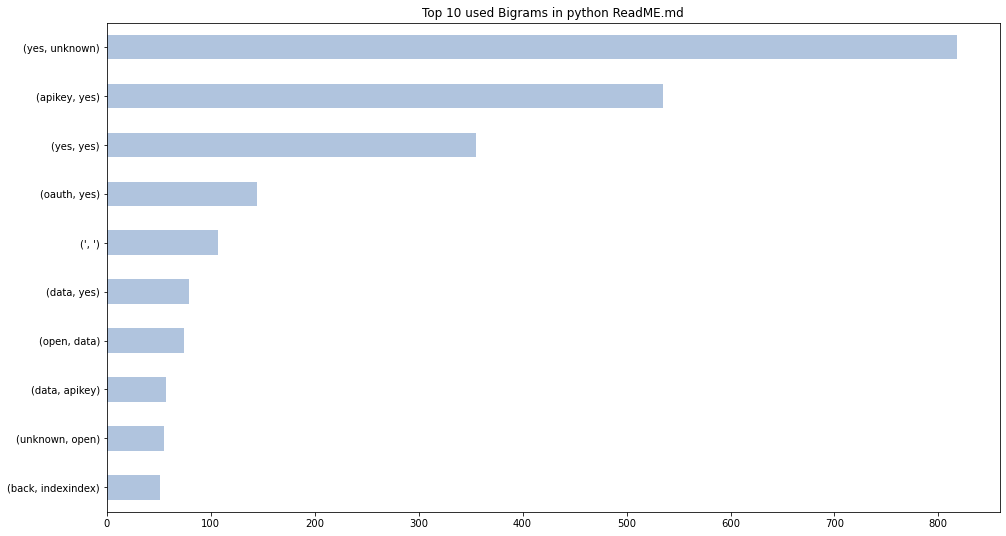

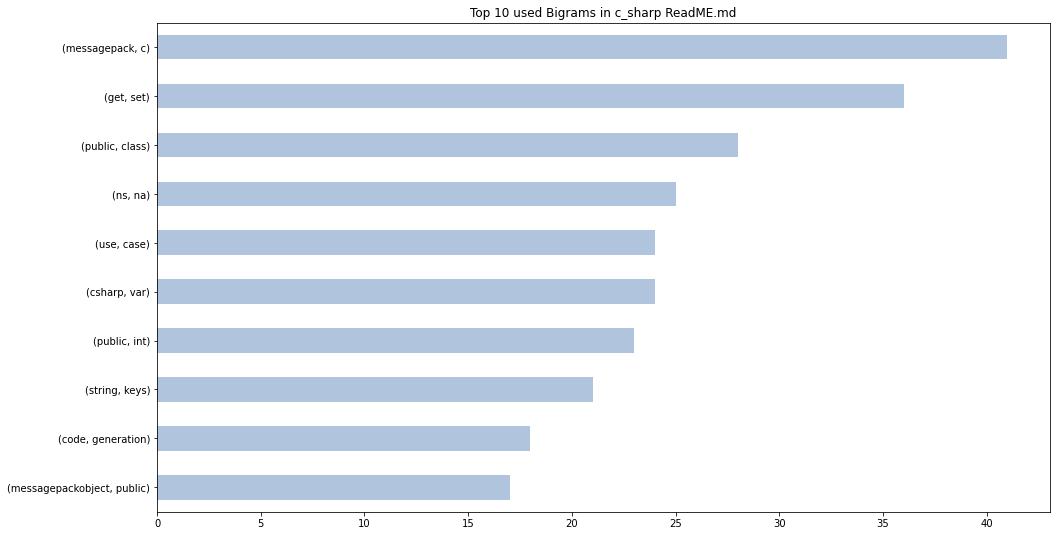

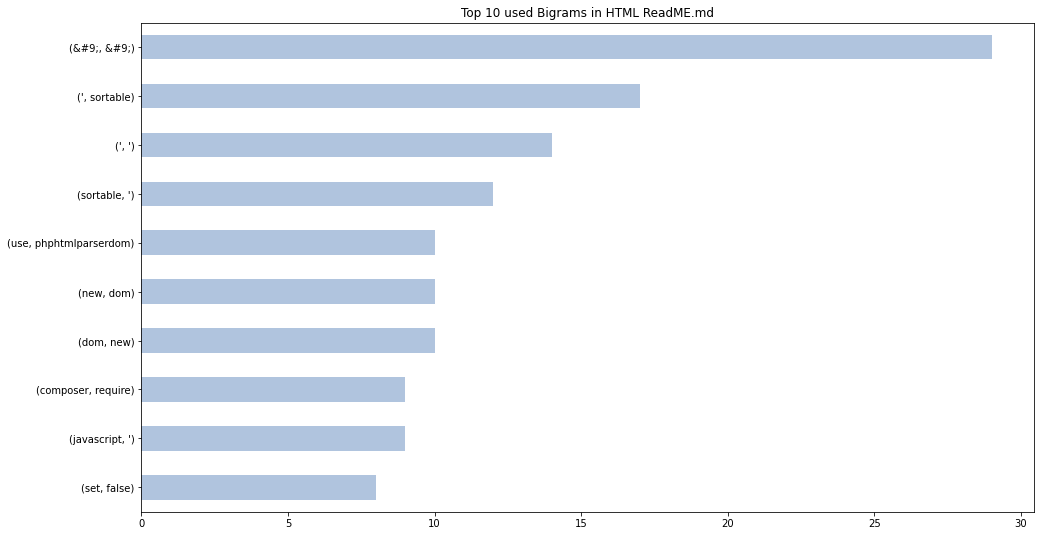

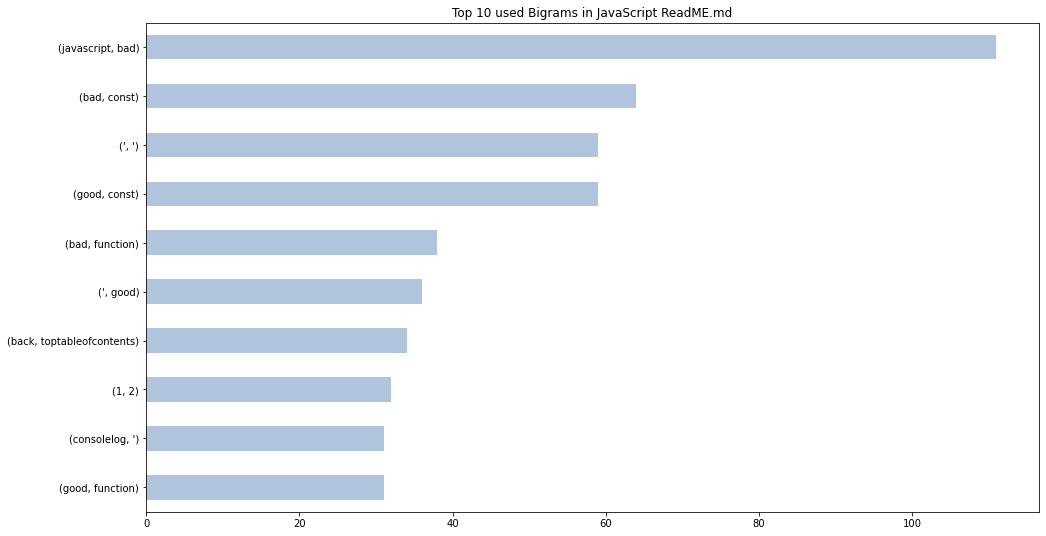

In [20]:
for key, value in lang_clean_words.items():
    plt.figure(figsize=(16, 9))
    pd.Series(nltk.bigrams(value.split())).value_counts(ascending = True).tail(10).plot.barh(color = 'lightsteelblue')
    plt.title(f'Top 10 used Bigrams in {key} ReadME.md')
    plt.show()

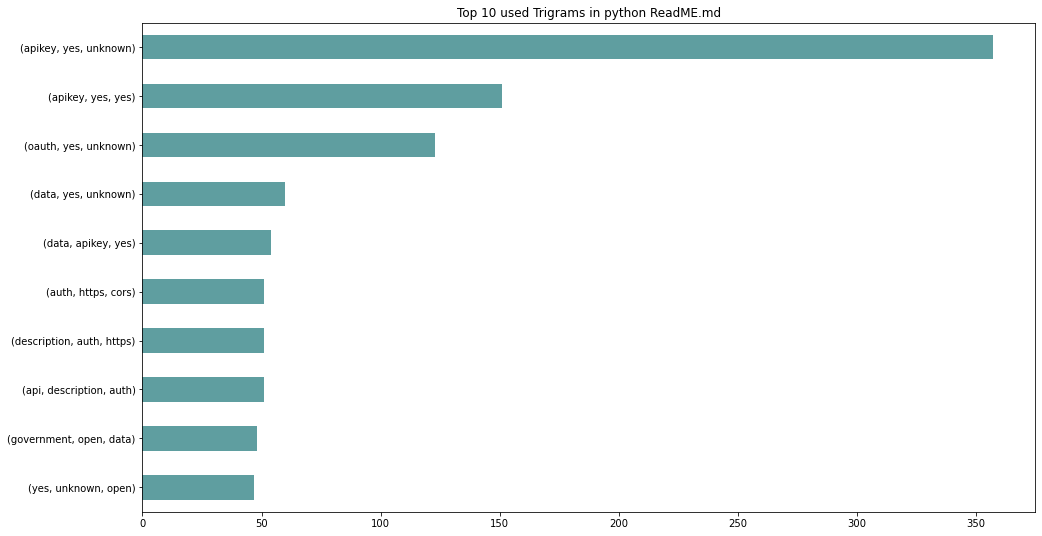

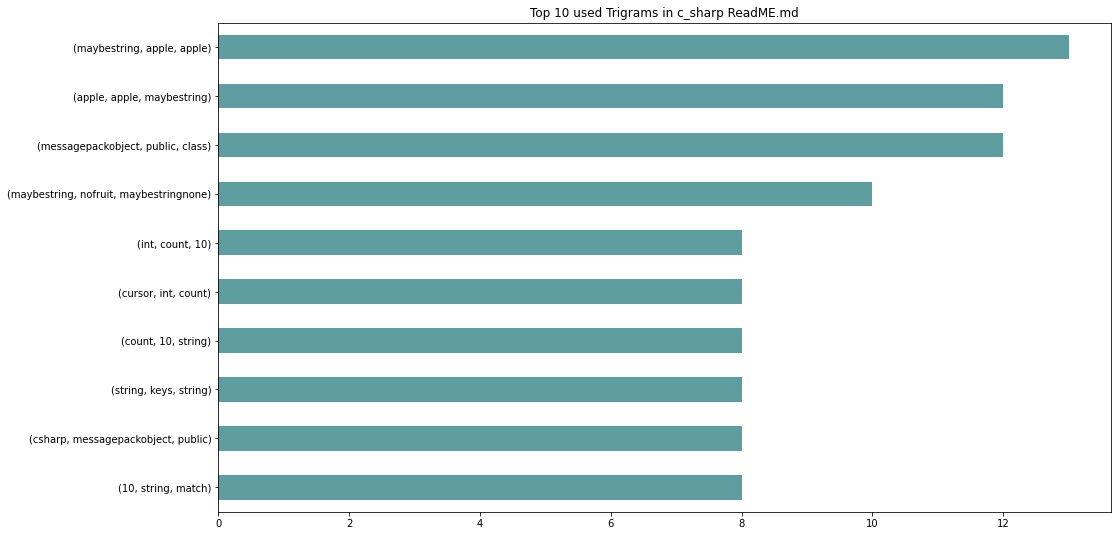

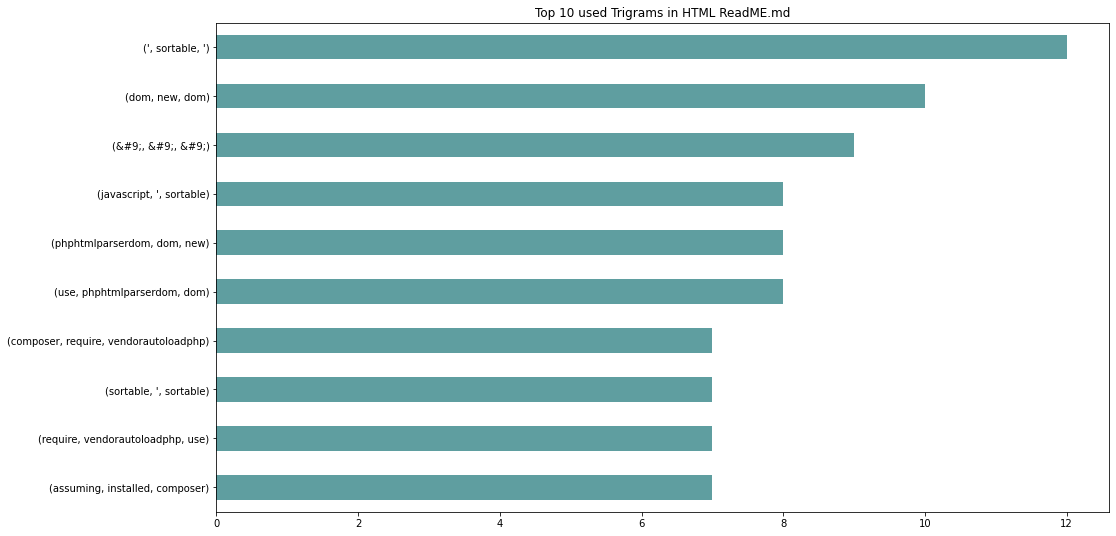

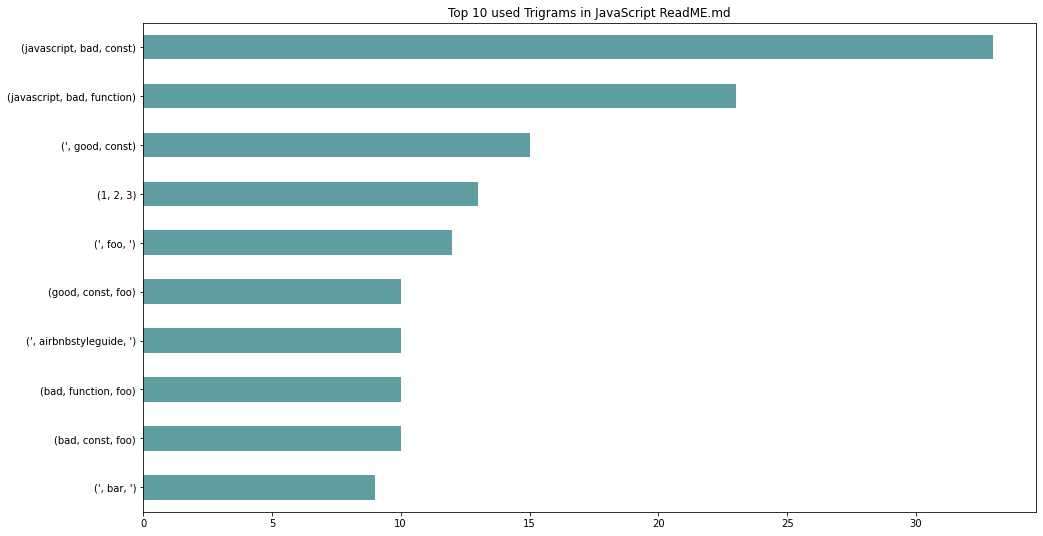

In [21]:
for key, value in lang_clean_words.items():
    plt.figure(figsize=(16, 9))
    pd.Series(nltk.trigrams(value.split())).value_counts(ascending = True).tail(10).plot.barh(color = 'cadetblue')
    plt.title(f'Top 10 used Trigrams in {key} ReadME.md')
    plt.show()

### Key takeaways from Exploring Bigrams and Trigrams:
 - Bigrams could prove most useful as top identifiable characteristics, Although trigrams for C# and JavaScript have some overlap so trigrams may not be as useful.

# Modeling

In [11]:
train, validate, test = prepare(acquire())

In [18]:
#Create a baseline model
print(f'Baseline Accuracy:{train.language.value_counts().idxmax()} {round(max(train.language.value_counts()) / train.shape[0] *100)}%' )

Baseline Accuracy:C# 31%


The cell above shows C# is the most commonly occuring langauge at 31% this will serve as our baseline

In [20]:
# Creating a Dataframe to hold all of our scores
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

In [21]:
# Creating our y train, validate and test
y_train = train.language
y_validate = validate.language
y_test = test.language
# Creating our x train validate and test using a function that 
# performs count vectorization on stemmed data
X_train,X_validate,X_test = vectorizer_split('stemmed')

In [22]:
def run_models():
    ''' This function loops through decision tree 20 times,
    with varying depths, random forerest 20 times with varying depths,
    knn 20 times with varying neighbors, it then stores those models to individual list 
    so they can be called upon later'''
    #Decision Tree
    ## Create a for loop that creates 20 decision tree models with increasingly larger depths.
    metrics = []
    tree_models = []
    for i in range(2, 22):
        # Make the model
        tree = DecisionTreeClassifier(max_depth=i, random_state=123)

        # Fit the model (on train and only train)
        tree = tree.fit(X_train, y_train)
        y_predictions = tree.predict(X_train)
        y_pred = tree.predict(X_validate)
        # Use the model
        in_sample_accuracy = round(tree.score(X_train, y_train),3)
    
        out_of_sample_accuracy = round(tree.score(X_validate, y_validate),3)
        
        in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label=0, average='micro'),3)
        
        out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0, average='micro'),3)
        output = {
            "max_depth": i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            "train_recall": in_sample_recall,
            "validate_recall": out_of_sample_recall
        }
        
        # This creates the df below 
        metrics.append(output)
        # tree_models will store all of my tree models incase i want them later
        tree_models.append(tree)
        
    tree_df = pd.DataFrame(metrics)
    tree_df["accuracy_difference"] = tree_df.train_accuracy - tree_df.validate_accuracy    
    
    # Random Forest
    ## Create a for loop that creates 20 Random Forrest models with increasingly larger depths.
    metrics2 = []
    forest_models = []
    for i in range(2, 22):
        # Make the model
        forest = RandomForestClassifier(max_depth=i, random_state=123)
    
        # Fit the model (on train and only train)
        forest = forest.fit(X_train, y_train)
        
        y_predictions = forest.predict(X_train)
        y_pred = forest.predict(X_validate)
        
        # Use the model
        in_sample_accuracy = round(forest.score(X_train, y_train),3)
        
        out_of_sample_accuracy = round(forest.score(X_validate, y_validate),3)
        
        in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0, average='micro'),3)
        
        out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0, average='micro'),3)
        
        output = {
            "max_depth": i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            "train_recall": in_sample_recall,
            "validate_recall": out_of_sample_recall
        }
        
        # This creates the df below
        metrics2.append(output)
        # tree_models will store all of my tree models incase i want them later
        forest_models.append(forest)
        
        
        
    forest_df = pd.DataFrame(metrics2)
    forest_df["accuracy_difference"] = forest_df.train_accuracy - forest_df.validate_accuracy
    

    knn_metrics = []
    knn_models = []
    # loop through different values of k
    for k in range(1, 21):
            
        # define the thing
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # fit the thing (remmeber only fit on training data)
        knn.fit(X_train, y_train)
        
        y_predictions = knn.predict(X_train)
        y_pred = knn.predict(X_validate)
        # use the thing (calculate accuracy)
        train_accuracy = round(knn.score(X_train, y_train),3)
        validate_accuracy = round(knn.score(X_validate, y_validate),3)
        train_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0,average='micro'),3)
        validate_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0,average='micro'),3)
        output = {
            "k": k,
            "train_accuracy": train_accuracy,
            "validate_accuracy": validate_accuracy,
            'train_recall':train_recall,
            "validate_recall":validate_recall
        }
        
        knn_metrics.append(output)
        knn_models.append(knn)
        # make a dataframe
    
    knn_df = pd.DataFrame(knn_metrics)
    knn_df["accuracy_difference"] = knn_df.train_accuracy - knn_df.validate_accuracy
        
    
    return tree_models, forest_models,knn_models, tree_df, forest_df, knn_df

In [23]:
# Run multiple variations of KNN, Decision Trees, and Random Forest
# with differing variationds of neighbors, branches, and trees
# saved those models to the coresponding dataframes so the best 
# performer could be called upon
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()

from sklearn import svm

# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_stemmed_CV', 'SVC_stemmed_CV', 'Decision_tree_stemmed_CV', 'Random_forest_stemmed_CV', 'KNN_stemmed_CV', 'Log_reg_stemmed_CV','SVC_OVO_stemmed_CV']
# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

This process is iterative, it will be peromed the exact same way for each variation of stemmed and lemmatized as well as the differing vectorizations of TFIDF and count vectorization. All results are being saved to the data frame score_df. In a seperate notebook each of the models where closely analyzed.

In [25]:
# Creating our x train validate and test using a function that 
# performs count vectorization on lemmatized data
X_train,X_validate,X_test = vectorizer_split('lemmatized')

In [26]:
# Run multiple variations of KNN, Decision Trees, and Random Forest
# with differing variationds of neighbors, branches, and trees
# saved those models to the coresponding dataframes so the best 
# performer could be called upon
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()

from sklearn import svm

# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_lemmatized_CV', 'SVC_lemmatized_CV', 'Decision_tree_lemmatized_CV', 'Random_forest_lemmatized_CV', 'KNN_lemmatized_CV', 'Log_reg_lemmatized_CV','SVC_OVO_lemmatized_CV']

# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [27]:
# Creating our x train validate and test using a function that 
# performs TFIDF vectorization on stemmed data
X_train,X_validate,X_test = tfidf_split('stemmed')

In [28]:
# Run multiple variations of KNN, Decision Trees, and Random Forest
# with differing variationds of neighbors, branches, and trees
# saved those models to the coresponding dataframes so the best 
# performer could be called upon
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()

from sklearn import svm

# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_stemmed_TFIDF', 'SVC_stemmed_TFIDF', 'Decision_tree_stemmed_TFIDF', 'Random_forest_stemmed_TFIDF', 'KNN_bigrams_stemmed_TFIDF', 'Log_reg_stemmed_TFIDF','SVC_OVO_stemmed_TFIDF']

# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train,X_validate, y_validate, model, name, score_df)

In [29]:
# Creating our x train validate and test using a function that 
# performs TFIDF vectorization on lemmatized data
X_train,X_validate,X_test = tfidf_split('lemmatized')

In [30]:
# Run multiple variations of KNN, Decision Trees, and Random Forest
# with differing variationds of neighbors, branches, and trees
# saved those models to the coresponding dataframes so the best 
# performer could be called upon
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()

from sklearn import svm

# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.validate_accuracy.idxmax()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_lemmatized_TFIDF', 'SVC_lemmatized_TFIDF', 'Decision_tree_lemmatized_TFIDF', 'Random_forest_lemmatized_TFIDF', 'KNN_lemmatized_TFIDF', 'Log_reg_lemmatized_TFIDF','SVC_OVO_lemmatized_TFIDF']

# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [31]:
# Creating a column to show us the difference between train and validate accuracy 
score_df["accuracy_difference"] = score_df.train_score - score_df.validate_score

In [32]:
# Sort the df_scores by the top 10 performing models highlights 
# the best validation score and the lowest difference between 
# the two.
score_df.sort_values(by='validate_score', ascending=False).head(10).style.highlight_max('validate_score').highlight_min('accuracy_difference')

,model_name,train_score,validate_score,accuracy_difference
23,Decision_tree_lemmatized_TFIDF,0.862069,0.720000,0.142069
5,Log_reg_stemmed_CV,1.000000,0.640000,0.360000
15,SVC_stemmed_TFIDF,1.000000,0.600000,0.400000
2,Decision_tree_stemmed_CV,0.913793,0.600000,0.313793
24,Random_forest_lemmatized_TFIDF,0.913793,0.600000,0.313793
4,KNN_stemmed_CV,0.465517,0.600000,-0.134483
6,SVC_OVO_stemmed_CV,0.913793,0.600000,0.313793
9,Decision_tree_lemmatized_CV,0.982759,0.600000,0.382759
11,KNN_lemmatized_CV,0.517241,0.600000,-0.082759
18,KNN_bigrams_stemmed_TFIDF,0.724138,0.560000,0.164138


# Key Takeaways

    Best performing model was a Decision Tree with a Max depth of 3
    
    Alot of models where over fitting, I tried to limit this but our data might just have some commonalities between them
    
    In a seperate notebook I actually used Recursive Feature Engineering to pick the top features and run them for models that suffer from the curse of dimesionality but that **DID NOT** beat this decision tree model. 
    
    Moving foward I feel confident that this is our best performing model

                   ============== Decisiocion Tree ================           
DecisionTreeClassifier(max_depth=3, random_state=123)
~~~~~~~~Test Scores~~~~~~~~~
              precision    recall  f1-score   support

          C#       0.36      1.00      0.53         4
        HTML       0.75      0.60      0.67         5
  JavaScript       1.00      0.40      0.57         5
      Python       1.00      0.57      0.73         7

    accuracy                           0.62        21
   macro avg       0.78      0.64      0.62        21
weighted avg       0.82      0.62      0.64        21



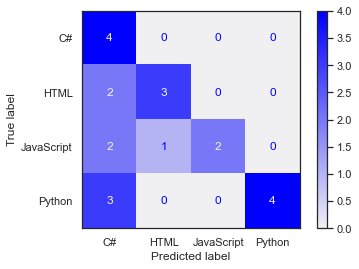


-------------------------------------------------------------------



In [33]:
# Running the test on unseen data and creating a confusion matrix
class_names = ['C#', 'HTML', 'JavaScript','Python' ]
make_models_and_print_metrics_test_data(tree_models[tree_df.validate_accuracy.idxmax()], 'Decisiocion Tree', X_train, y_train, X_test, y_test, class_names)

    The best performing model on unseen test data doubled baseline prediction with an accuracy score of 62%. It looks like C# gives our models the largest problem. Most misclasifications where because of C#. In the future we may look at further cleaning of common words to reduce this misclassification

# Conclusion

    Our model could accuratley predict the language of the repos by 62% which had beat double the baseline model of 31%. Further cleaning of common words or stop words may improve the accuracy of the model. C# gave our models the hardest time with misclassifications of every other langauge falling under the C# moniker. 

### Next Steps

    With more time, we would like to use more repositories to potentially find more words that can help predict the programming language used

# Thank You